In [120]:
import numpy as np
import matplotlib.pyplot as plt
import functools as ft
from scipy.linalg import expm, sqrtm

# Projected ensemble simulation

We define a Hamiltonian following [Cotler et al.](https://doi.org/10.1103/PRXQuantum.4.010311). It is a one-dimensional spin chain with single-site mixed field terms and nearest neighbour interaction terms, without periodic boundary conditions.

## Time evolution: parameters, Hamiltonian, initial state

To simulate the dynamics use a naive approach:
- State is a vector, Hamiltonian is a matrix
- Exponentiate Hamiltonian to get time evolution operator
- Matvec multiplication to get final state $\ket{\Psi} = U \ket{\Psi_0}$

With my laptop this is only achievable for $N_A = 1$ and $N_B$ up to about $9$, which hopefully is sufficiently large to get a result.

In [121]:
## Hamiltonian: Quantum Ising spin with mixed fields (QIMF)

# Parameters (as per Cotler et al.)
h_x = 0.8090
h_y = 0.9045
J = 1
N_A = 2
N_B = 7
N = N_A + N_B

# Pauli matrices
sx = np.array([[0,1],[1,0]]) ;  sy = np.array([[0,-1j],[1j,0]])

# Single site term
H1 = h_x * sx + h_y * sy

# Interaction term
H2 = J * np.kron(sx,sx)

# Hamiltonian as a matrix
H = np.zeros((2**N,2**N),dtype='complex128')
for i in range(N):
    H += ft.reduce(np.kron, [np.identity(2**i), H1, np.identity(2**(N-i-1))])
for i in range(N-2):
    H += ft.reduce(np.kron, [np.identity(2**i), H2, np.identity(2**(N-i-2))])

# Initial state: all |0>
Psi0 = np.zeros(2**N)
Psi0[0] = 1

## Extraxting projected ensemble

Next, a function to get the projected ensemble as a list, in the form [ [p_1, state_1], ... , [p_N, state_N] ], with the states numpy arrays in computational basis for subsystem $A$. We take $A$ to be the first $N_A$ qubits. I have made two functions:
- Firstly, using projectors and looping over all measurement outcomes on B, as you would do it by hand from a generic $\ket{\Psi}$;
- Secondly, realising that in the way $\ket{\Psi}$ is stored as coefficients in the computational basis, the coefficients can pretty much be read off without need for projection.

In [122]:
# First, getting a projected ensemble from the most literal, obvious way: by defining projectors for each measurement outcome

def PrEns(Psi):
    # Define empty ensemble
    PrEns = np.empty((2**N_B, 2)).tolist()

    # Loop over |z_B>, make projectors
    for i in range(2**N_B):
        z_B = np.zeros(2**N_B)
        z_B[i] = 1
        P = np.kron(np.identity(2**N_A), np.outer(z_B,z_B))

        Psi_zB = P @ Psi

        # Pick out probability (norm), then normalise, then get PsiA
        PrEns[i][0] = np.linalg.norm(Psi_zB) ** 2
        Psi_zB /= np.linalg.norm(Psi_zB)
        PrEns[i][1] = Psi_zB.reshape(2**N_A, 2**N_B)[:,i]
    
    return PrEns

# Then I realised that with the way things are stored we can just read it off

def PrEns_quick(Psi):
    PrEns = np.empty((2**N_B, 2)).tolist()

    for i in range(2**N_B):
        PsiA = Psi.reshape(2**N_A, 2**N_B)[:,i]
        PrEns[i][0] = np.linalg.norm(PsiA) ** 2
        PrEns[i][1] = PsiA / np.linalg.norm(PsiA)
    
    return PrEns

# A quick check confirms these give the same results, so no outer products / matrix vector multiplication is needed.


## Moments

Next: get the moments from the distributions. These are straightforwardly described as either $d \times \cdots \times d$ rank-$2k$ tensors or as $d^k \times d^k$ matrices. Here I use matrices for convenience.

Firstly, some functions that give me moments of the Haar ensemble from the permutation-representation formula in [Cotler et al.](https://doi.org/10.1103/PRXQuantum.4.010311) appendix A. I have done this for $k = 1, 2, 3$ 'by hand', but for general dimension $d$ of the Hilbert space $\mathcal{H}_A$. Not sure if it can easily be done for general $k$.

Secondly, a function that gives me moments for a projected ensemble as those extracted from the quenched states.

As a test, I constructed moments from the minimal $3$-design with $d = 2$ (positive and negative eigenvalue spin eigenstates in the three orthogonal directions), and these gave the same results as the functions generating the Haar moments.

In [123]:
# First 3 moments of the Haar ensemble

def rho_1_Haar(d):
    rho_1 = np.identity(d, dtype='complex128') / d
    return rho_1

def rho_2_Haar(d):
    rho_2 = np.zeros((d**2,d**2), dtype='complex128')
    
    # Identity
    rho_2 += np.identity(d**2, dtype='complex128')

    # Swap
    for i in range(d):
        for j in range(d):
            ket_i = np.zeros(d)
            ket_i [i] = 1
            ket_j = np.zeros(d)
            ket_j [j] = 1

            ket_ij = np.kron(ket_i, ket_j)
            ket_ji = np.kron(ket_j, ket_i)

            rho_2 += np.outer(np.conjugate(ket_ji), ket_ij)
        

    return rho_2 / (d * (d+1) )

def rho_3_Haar(d):
    rho_3 = np.zeros((d**3,d**3), dtype='complex128')

    # Identity
    rho_3 += np.identity(d**3, dtype='complex128')

    for i in range(d):
        for j in range(d):
            for k in range(d):
                ket_i = np.zeros(d)
                ket_i[i] = 1
                ket_j = np.zeros(d)
                ket_j[j] = 1
                ket_k = np.zeros(d)
                ket_k[k] = 1

                ket_ijk = ft.reduce(np.kron, [ket_i, ket_j, ket_k])

                # swaps
                ket_jik = ft.reduce(np.kron, [ket_j, ket_i, ket_k])
                ket_ikj = ft.reduce(np.kron, [ket_i, ket_k, ket_j])
                ket_kji = ft.reduce(np.kron, [ket_k, ket_j, ket_i])
                rho_3 += np.outer(np.conjugate(ket_jik), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_ikj), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_kji), ket_ijk)

                # 3-cycles
                ket_jki = ft.reduce(np.kron, [ket_j, ket_k, ket_i])
                ket_kij = ft.reduce(np.kron, [ket_k, ket_i, ket_j])
                rho_3 += np.outer(np.conjugate(ket_jki), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_kij), ket_ijk)

    return rho_3 / (d * (d+1) * (d+2))

# Moments from projected ensemble

def rho_PrEns(PrEns, k):
    
    d = np.size(PrEns[0][1])
    rho_k = np.zeros((d**k, d**k), dtype='complex128')

    for i in range(len(PrEns)):
        p_i = PrEns[i][0]
        state_i = PrEns[i][1]
        k_copies = ft.reduce(np.kron, [state_i for i in range(k)])

        rho_k += p_i * np.outer(np.conjugate(k_copies), k_copies)
    
    return rho_k


## Simulations

Now it's time to just do the whole thing. Simulate, find the projected ensembles and the moments, and output.

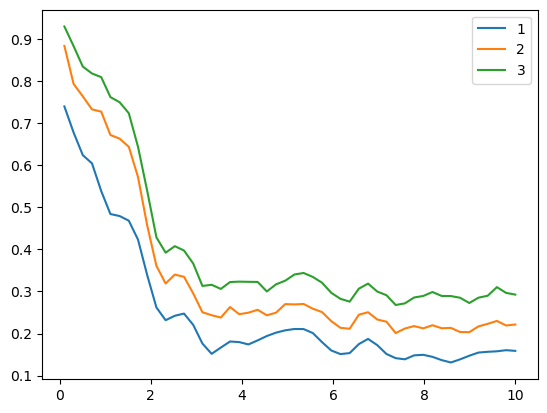

In [124]:
# A test: trace distances for the density matrix

times = np.linspace(0.1,10,50)
dist1 = np.zeros(np.size(times))
dist2 = np.zeros(np.size(times))
dist3 = np.zeros(np.size(times))
rho_1 = rho_1_Haar(4)
rho_2 = rho_2_Haar(4)
rho_3 = rho_3_Haar(4)

for i, t in enumerate(times):
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = PrEns_quick(Psi)

    # Get the density matrices
    rho_1_sim = rho_PrEns(PrEns, 1)
    rho_2_sim = rho_PrEns(PrEns, 2)
    rho_3_sim = rho_PrEns(PrEns, 3)

    dist1[i] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
    dist2[i] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
    dist3[i] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig = plt.figure()
plt.plot(times, dist1, label='1')
plt.plot(times, dist2, label='2')
plt.plot(times, dist3, label='3')
plt.legend()
plt.show()


